In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


# FID Calculation

inc_model = keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(150,150,3))


# scale an array of images to a new size
def scale_images(images, new_shape): 
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = np.resize(image, new_shape)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2, verbose=True):
    # preprocessing
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (150,150,3))
    images2 = scale_images(images2, (150,150,3))

    images1 = keras.applications.inception_v3.preprocess_input(images1)
    images2 = keras.applications.inception_v3.preprocess_input(images2)
    # calculate activations
    act1 = model.predict(images1, verbose=verbose)
    act2 = model.predict(images2, verbose=verbose)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False, dtype=np.csingle)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False, dtype=np.csingle)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = np.sqrt(sigma1*sigma2)
    # check and correct imaginary numbers from sqrt
    covmean = np.real(covmean)
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return np.real(fid)

# define two fake collections of images
images1 = np.random.randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = np.random.randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))

print(calculate_fid(inc_model, images1, images2))
print(calculate_fid(inc_model, images1, images1))
print(calculate_fid(inc_model, images2, images2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
43.57998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
0.0


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 
import scipy

DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

## Cross Dataset

In [2]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, input_dim, fc_dim, latent_dim):
        super().__init__()
        
        self.fwd = nn.Sequential(
            nn.Linear(input_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, fc_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_log_var = nn.Linear(fc_dim, latent_dim)
                    
    def forward(self, x):
        x = self.fwd(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, fc_dim, output_dim):
        super().__init__()

        self.fwd = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, fc_dim),
            nn.ReLU(),
            nn.Linear(fc_dim, output_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fwd(x)

In [3]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, input_dim, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(input_dim, fc_dim, latent_dim).to(DEVICE)
        self.decoder = Decoder(latent_dim, fc_dim, input_dim).to(DEVICE)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    def sample_z_uniform(self, centre, widths) :
        temp = torch.rand_like(centre) - 0.5 # centred at origin 
        return torch.exp(widths)*2*temp + centre
    
    def forward(self, x, point=False, uniform=False):
        mu, log_var = self.encoder(x)
        if point : z = mu 
        elif uniform : z = self.sample_z_uniform(mu, log_var)
        else : z = self.sample_z(mu, log_var).to(DEVICE)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1]).mean()
        
        return kl_loss, recon_loss, recon, x

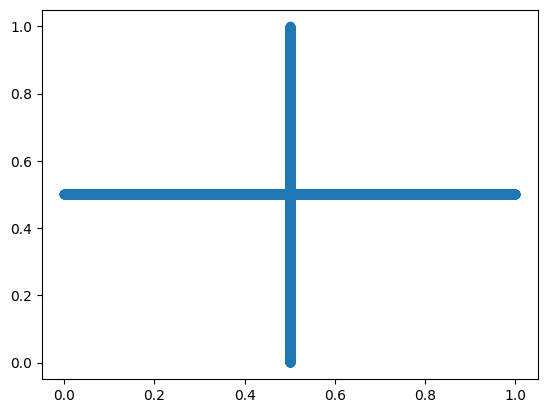

In [4]:
num_points = 10000
filter = lambda x : x # if x>0.55 or x<0.45 else 0.5 + (x>0)*0.05
X1 = [0.5]*num_points
Y1 = [filter(x) for x in torch.rand(num_points)]
X2 = [filter(x) for x in torch.rand(num_points)]
Y2 = [0.5]*num_points
data1 = [(x,y) for x,y in zip(X1,Y1)]
data2 = [(x,y) for x,y in zip(X2,Y2)]
cross_data = data1 + data2

plt.scatter([i[0] for i in cross_data], [i[1] for i in cross_data])

In [5]:
class cross_dataset(torch.utils.data.Dataset) :
    def __init__(self, arr, transforms=None, subset=0) :
        self.arr = arr
        self.transforms = transforms
        if subset>0 : self.arr = self.arr[:subset]
    def __len__(self) :
        return len(self.arr)
    def __getitem__(self, idx) :
        Data = self.arr[idx]
        if self.transforms :
            Data = self.transforms(Data)
        return torch.tensor(Data)


In [7]:
input_dim = 2
fc_dim = 15
latent_dim = 2
epochs = 4000
device = DEVICE
print(f'{device=}')

dataset = cross_dataset(cross_data)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

model = VAE(input_dim, fc_dim, latent_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:1'
params 666


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0, loss1 0.07810136675834656, loss2 1.3882970809936523
Epoch 300, loss1 0.007121264468878508, loss2 1.3852101564407349
Epoch 600, loss1 0.3640581965446472, loss2 1.3378695249557495
Epoch 900, loss1 0.772189736366272, loss2 1.2825566530227661
Epoch 1200, loss1 0.810981810092926, loss2 1.2780250310897827
Epoch 1500, loss1 0.8081575036048889, loss2 1.2774590253829956
Epoch 1800, loss1 0.8039783835411072, loss2 1.2783294916152954
Epoch 2100, loss1 0.8079183101654053, loss2 1.2788043022155762
Epoch 2400, loss1 0.807869017124176, loss2 1.277646541595459
Epoch 2700, loss1 0.8092077970504761, loss2 1.277620792388916
Epoch 3000, loss1 0.8085944652557373, loss2 1.2773174047470093
Epoch 3300, loss1 0.8101195693016052, loss2 1.27884042263031
Epoch 3600, loss1 0.8108020424842834, loss2 1.2773303985595703
Epoch 3900, loss1 0.8085960745811462, loss2 1.2778232097625732


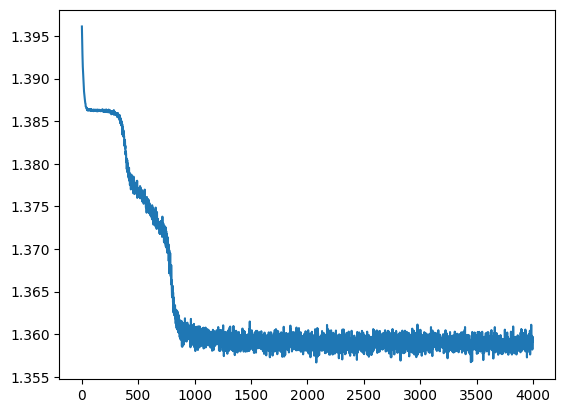

In [8]:
losslog = []
recons = []
xs = []
for epoch in tqdm(range(epochs)):
    for i, (images) in enumerate(train_loader):
        images = images.to(DEVICE)
        recon, mu, log_var = model(images)
        loss1, loss2, recon, x = model.compute_loss(images, recon, mu, log_var)
        with torch.no_grad() : recons.append(recon.detach()); xs.append(x.detach())
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%300==0 : 
        tqdm.write(f'Epoch {epoch}, loss1 {loss1.item()}, loss2 {loss2.item()}')

plt.plot(losslog)

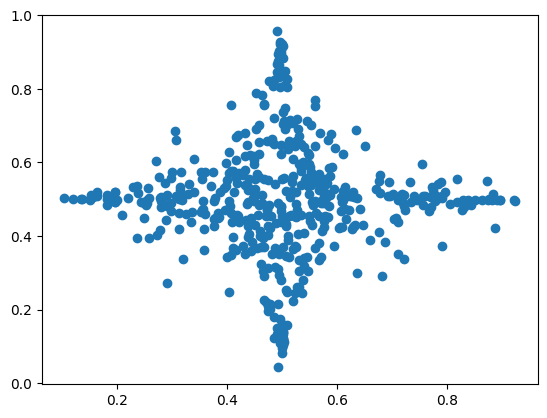

In [27]:
## generate new images by VAE, sampling from N(0,I)
sample_zs = torch.randn(500, latent_dim).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

plt.scatter(generated_imgs[:,0], generated_imgs[:,1]);

In [35]:
THRESH = 0.05

generated_imgs_centred = generated_imgs - 0.5
val = np.abs(generated_imgs_centred).max(axis=-1)
distances = (np.linalg.norm(generated_imgs_centred, axis=-1)**2 - val**2)**0.5
num_corr = sum(distances<=THRESH)
distances.shape, distances.min(), distances.max(), f'{num_corr} / {len(distances)} correct'

((500,), 0.0, 0.21010706, '380 / 500 correct')

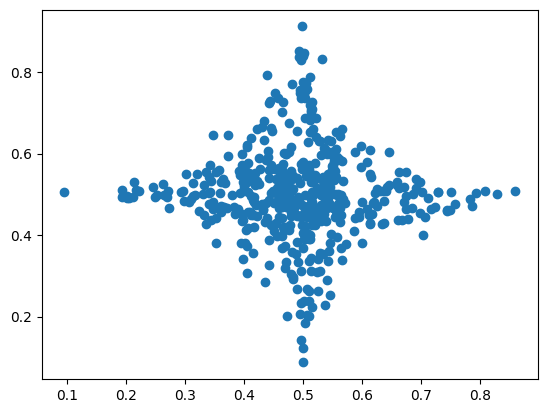

In [86]:
## generate new images by VAE, sampling from N(mu, sigma)

with torch.no_grad() : pivots = model.encoder(next(iter(train_loader)).to(DEVICE))[0].cpu()
mu = pivots.mean(dim=0)
sigma = torch.tensor(scipy.linalg.sqrtm(pivots.transpose(0,1).cov()))
sample_zs = (mu + torch.randn(500, latent_dim)@sigma).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

plt.scatter(generated_imgs[:,0], generated_imgs[:,1])

In [87]:
THRESH = 0.05

generated_imgs_centred = generated_imgs - 0.5
val = np.abs(generated_imgs_centred).max(axis=-1)
distances = (np.linalg.norm(generated_imgs_centred, axis=-1)**2 - val**2)**0.5
num_corr = sum(distances<=THRESH)
distances.shape, distances.min(), distances.max(), f'{num_corr} / {len(distances)} correct'

((500,), 0.0, 0.14436936, '398 / 500 correct')

In [88]:
## sampling from langevin MC

gauss_std = 1/3

def potential(z, encodings, sigma=gauss_std, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).max(-1).values
    if pot : return -torch.log(ans)
    return ans

def log_Q(potential, encodings, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z, encodings).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=100000, step=0.001, k=50):
    burn_in = 10000
    weight = 10.
    Z0 = torch.tensor([2., 0.]).view(1,-1) # torch.randn(1, encodings.shape[-1])
    Zi = Z0
    samples = []
    grads = []
    acc = []
    pbar = tqdm(range(k*n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi, encodings).mean()
        grad = torch.autograd.grad(u, Zi)[0]; grads.append(grad)
        prop_Zi = Zi.detach() - step * weight *grad + np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
        log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step) - log_Q(potential, encodings, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi; acc.append(1)
        else : acc.append(0)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in::k], grads, acc, np.concatenate(samples, 0)[:burn_in]

  0%|          | 0/110000 [00:00<?, ?it/s]

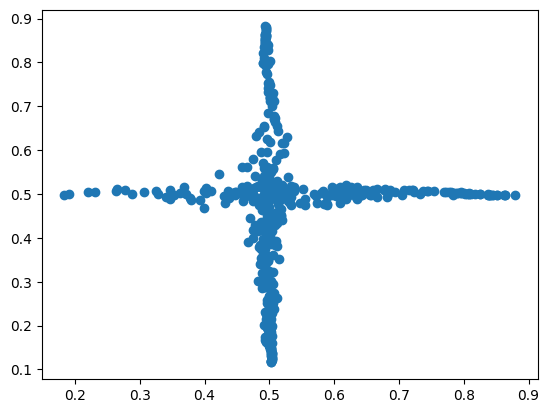

In [94]:
latents, grads, acc, burns = metropolis_adjusted_langevin_algorithm(potential, pivots, n_samples=500, k=200)
with torch.no_grad() : generations = model.decoder(torch.tensor(latents).to(next(model.decoder.parameters()).device)).cpu()

plt.scatter(generations[:,0], generations[:,1])

In [101]:
THRESH = 0.05

generated_imgs_centred = generations.numpy() - 0.5
val = np.abs(generated_imgs_centred).max(axis=-1)
distances = (np.linalg.norm(generated_imgs_centred, axis=-1)**2 - val**2)**0.5
num_corr = sum(distances<=THRESH)
distances.shape, distances.min(), distances.max(), f'{num_corr} / {len(distances)} correct'

((500,), 0.0, 0.04455101, '500 / 500 correct')

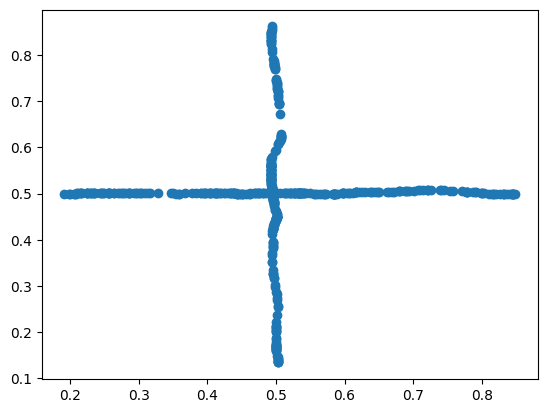

In [104]:
## baseline : regenerations

with torch.no_grad() : pivots = model.encoder(next(iter(train_loader)).to(DEVICE))[0].cpu()
sample_zs = pivots[::len(pivots)//500].to(DEVICE)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs)

plt.scatter(generated_imgs[:,0], generated_imgs[:,1])

In [105]:
THRESH = 0.05

generated_imgs_centred = generated_imgs - 0.5
val = np.abs(generated_imgs_centred).max(axis=-1)
distances = (np.linalg.norm(generated_imgs_centred, axis=-1)**2 - val**2)**0.5
num_corr = sum(distances<=THRESH)
distances.shape, distances.min(), distances.max(), f'{num_corr} / {len(distances)} correct'

((500,), 0.0, 0.008005907, '500 / 500 correct')

In [107]:
torch.save(model, 'models/VAE_cross_finalRes.pt')

## CIFAR-10

In [5]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        convs = []
        prev_dim = input_dim
        for conv_dim in conv_dims:
            convs.append(nn.Sequential(
                nn.Conv2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.convs = nn.Sequential(*convs)
        
        prev_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(prev_dim, fc_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_log_var = nn.Linear(fc_dim, latent_dim)
                    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        mu = self.fc_mu(x) # .clip(min=-20., max=20.)
        log_var = self.fc_log_var(x) # .clip(min=-20., max=20.)
        return mu, log_var
    
class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, image_size, conv_dims, output_dim):
        super().__init__()
        
        fc_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU()
        )
        self.conv_size = image_size // (2 ** len(conv_dims))
        
        de_convs = []
        prev_dim = conv_dims[-1]
        for conv_dim in conv_dims[::-1]:
            de_convs.append(nn.Sequential(
                nn.ConvTranspose2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.de_convs = nn.Sequential(*de_convs)
        self.pred_layer = nn.Sequential(
            nn.Conv2d(prev_dim, output_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
            # nn.ReLU()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.size(0), -1, self.conv_size, self.conv_size)
        x = self.de_convs(x)
        x = self.pred_layer(x)
        return x

In [6]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        # recon_loss = ((recon - x)**2).mean([1,2,3]).mean()
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        
        return kl_loss, recon_loss

In [7]:
image_size = 32
conv_dims = [64, 128, 256]
fc_dim = 1024
latent_dim = 400

batch_size = 4096
epochs = 100

transform=transforms.Compose([
    transforms.ToTensor()
])

device = DEVICE
print(f'{device=}')

dataset = datasets.CIFAR10('data', train=True, download=True,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = VAE(image_size, 3, conv_dims, fc_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:1'
Files already downloaded and verified
params 7989283


In [22]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        recon, mu, log_var = model(images)
        loss1, loss2 = model.compute_loss(images, recon, mu, log_var)
        loss = 0.1*loss1 + loss2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}, loss1 {loss1.item()}, loss2 {loss2.item()}')
    if epoch==50 : optimizer.param_groups[0]['lr'] /= 10

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 2132.9541015625, loss1 222.7034912109375, loss2 2110.683837890625
Epoch 5, loss 1989.6600341796875, loss1 34.53501892089844, loss2 1986.20654296875
Epoch 10, loss 1925.8170166015625, loss1 55.681365966796875, loss2 1920.2489013671875
Epoch 15, loss 1914.9642333984375, loss1 66.36080169677734, loss2 1908.328125
Epoch 20, loss 1889.758056640625, loss1 83.92655944824219, loss2 1881.3653564453125
Epoch 25, loss 1870.6536865234375, loss1 92.94673919677734, loss2 1861.3590087890625
Epoch 30, loss 1846.2037353515625, loss1 106.1313705444336, loss2 1835.590576171875
Epoch 35, loss 1854.6898193359375, loss1 100.16207122802734, loss2 1844.673583984375
Epoch 40, loss 1827.4327392578125, loss1 105.33988189697266, loss2 1816.8988037109375
Epoch 45, loss 1825.1650390625, loss1 105.57936096191406, loss2 1814.6070556640625
Epoch 50, loss 1823.271240234375, loss1 102.47073364257812, loss2 1813.024169921875
Epoch 55, loss 1823.224365234375, loss1 100.75137329101562, loss2 1813.149169921875

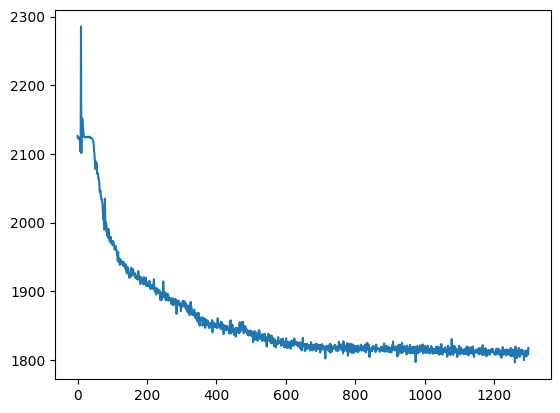

In [23]:
plt.plot(losslog[:])

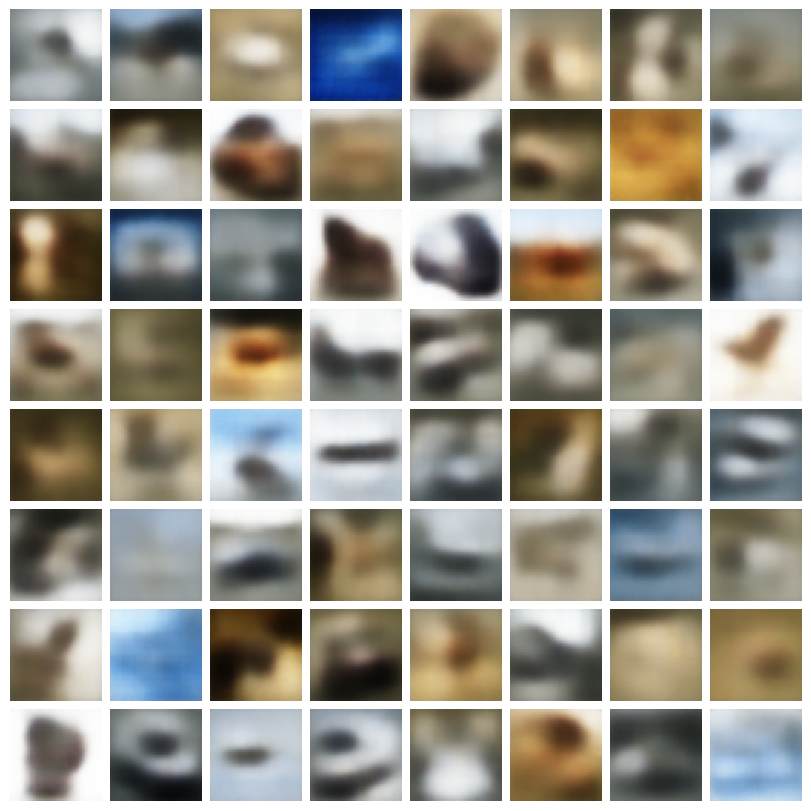

In [9]:
## generate new images by VAE
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
n_cols, n_rows = 8, 8

sample_zs = model.encoder(next(iter(test_loader))[0].to(DEVICE))[0].cpu()
# sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad(): 
    generated_imgs = model.decoder(sample_zs.to(DEVICE))
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, 3, image_size, image_size).swapaxes(2,3).swapaxes(3,4)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col])
        f_ax.axis("off")

In [48]:
torch.save(model, 'models/VAE_cifar10.pt')

In [8]:
model = torch.load('models/VAE_cifar10.pt')

In [33]:
# generating by sampling from N(0, I)
test_dataset = datasets.CIFAR10('data', train=True, download=True,
                       transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.to(DEVICE))
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 3, image_size, image_size)
images_actual = test_dataset.data[:1000].swapaxes(-1,-2).swapaxes(-2,-3)

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

Files already downloaded and verified
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step
FID (1000 images) : 31.373722076416016


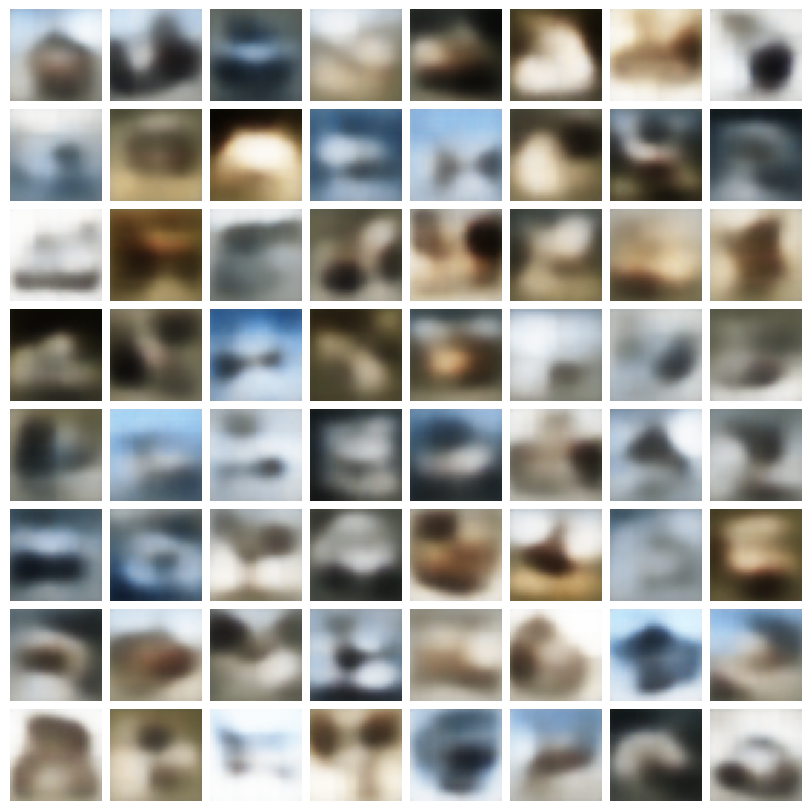

In [36]:
# sampling from N(mu, sigma)
import scipy

with torch.no_grad() : pivots = model.encoder(next(iter(train_loader))[0].cuda(1))[0].cpu()
mu = pivots.mean(dim=0, keepdims=True)
sigma = scipy.linalg.sqrtm(pivots.transpose(0,1).cov()).real
sample_zs = (mu + torch.randn(64, latent_dim)@sigma).to('cuda:1')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, 3, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col].swapaxes(0,1).swapaxes(1,2), cmap="gray")
        f_ax.axis("off")

In [37]:
test_dataset = datasets.CIFAR10('data', train=True, download=True,
                       transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = (mu + torch.randn(1000, latent_dim)@sigma)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda(1))
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 3, image_size, image_size)
images_actual = test_dataset.data[:1000].swapaxes(-1,-2).swapaxes(-2,-3)

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

Files already downloaded and verified
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step
FID (1000 images) : 48.454742431640625


/tmp/ipykernel_73136/1861139613.py:53: RuntimeWarning: invalid value encountered in cast
  generated_imgs2 = np.array(generated_imgs[:64] * 255, dtype=np.uint8).reshape(8, 8, 3, image_size, image_size)


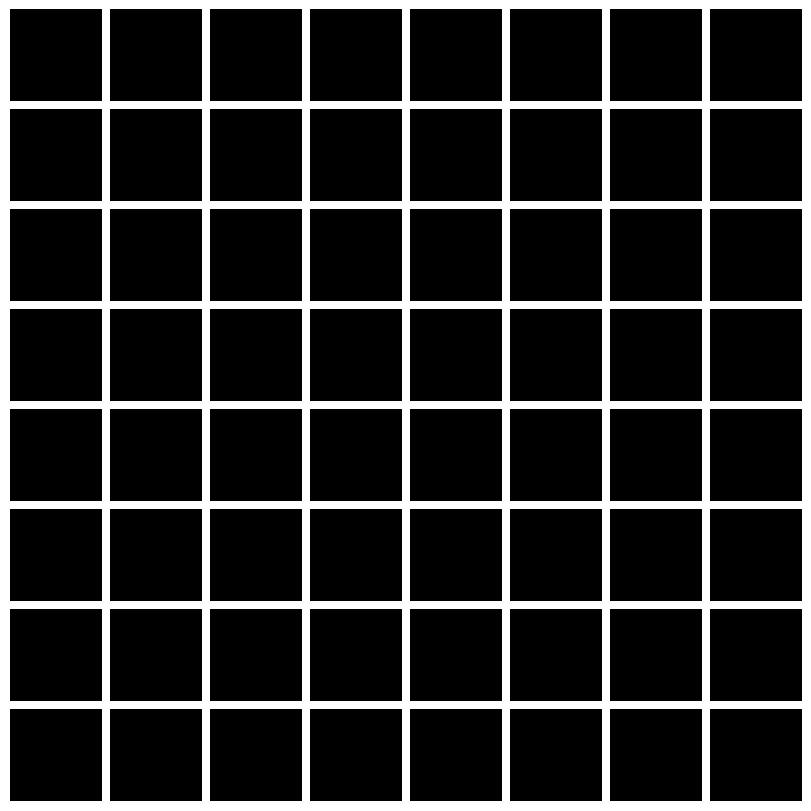

In [45]:
# sampling from Langevin MC

## sampling from langevin MC

#### HPARAMS ####
GAUSE_STD = 15.
STEP = 30.
WEIGHT = 70.
K = 70
#################

def potential(z, encodings, sigma=GAUSE_STD, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).max(-1).values
    if pot : return -torch.log(ans)
    return ans

def log_Q(potential, encodings, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z, encodings).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=100000, step=0.001, k=50):
    burn_in = 10000
    weight = WEIGHT
    Z0 = torch.randn(1, encodings.shape[-1])
    Zi = Z0
    samples = []
    grads = []
    acc = []
    pbar = tqdm(range(k*n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi, encodings).mean()
        grad = torch.autograd.grad(u, Zi)[0]; grads.append(grad)
        prop_Zi = Zi.detach() - step * weight *grad + np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
        log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step) - log_Q(potential, encodings, prop_Zi, Zi, step)
        if True : #torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi; acc.append(1)
        else : acc.append(0)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in::k], grads, acc, np.concatenate(samples, 0)[:burn_in]

# latents, grads, acc, burns = metropolis_adjusted_langevin_algorithm(potential, pivots, n_samples=1000, k=K, step=STEP)

model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(torch.tensor(latents, device='cuda:1'))
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs2 = np.array(generated_imgs[:64] * 255, dtype=np.uint8).reshape(8, 8, 3, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col].swapaxes(0,1).swapaxes(1,2))
        f_ax.axis("off")